In [ ]:
import mne
import os

# Directorio donde se encuentran los archivos EEG
directorio_datos = r"C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms"

# Diccionario para almacenar los registros EEG por condición
registros_eeg = {"congruente": {}, "incongruente_rel": {}, "incongruente_no_rel": {}}

# Condiciones y sus sufijos de archivo correspondientes
condiciones = {
    "congruente": "PWI_CON",
    "incongruente_rel": "PWI_INC_REL",
    "incongruente_no_rel": "PWI_INC_UNREL"
}

# Sujetos a excluir de la carga de archivos, pero deben aparecer en el diccionario
sujetos_excluir = {11, 30}

# Iterar sobre los 40 sujetos para cada condición
for sujeto_id in range(1, 41):
    for condicion, sufijo_archivo in condiciones.items():
        sujeto_key = f"Sujeto_{sujeto_id}"

        if sujeto_id in sujetos_excluir:
            registros_eeg[condicion][sujeto_key] = None
            print(f"{sujeto_key} excluido de la carga en '{condicion}', asignado como None.")
            continue  # Saltar a la siguiente condición

        nombre_archivo = f"S{sujeto_id}_{sufijo_archivo}.set"
        ruta_archivo = os.path.join(directorio_datos, nombre_archivo)

        try:
            # Cargar el archivo .set como un registro continuo
            registro_continuo = mne.io.read_raw_eeglab(ruta_archivo)
            registros_eeg[condicion][sujeto_key] = registro_continuo
            print(f"{nombre_archivo} cargado exitosamente en '{condicion}'.")
        except FileNotFoundError:
            registros_eeg[condicion][sujeto_key] = None
            print(f"{nombre_archivo} no encontrado en '{condicion}'.")
        except Exception as e:
            registros_eeg[condicion][sujeto_key] = None
            print(f"Error al cargar {nombre_archivo} en '{condicion}': {e}")

# Resumen de la carga de archivos
print("\nResumen de las cargas:")
for condicion, sujetos in registros_eeg.items():
    print(f"\nCondición: {condicion}")
    for sujeto, datos in sujetos.items():
        estado = "Cargado" if datos is not None else "No cargado"
        print(f"  {sujeto}: {estado}")


In [7]:
registros_eeg['congruente']['Sujeto_1'].get_data()

array([[ 8.12576175e-07,  8.17521453e-07,  8.28951180e-07, ...,
         9.37588930e-07,  8.24305713e-07,  7.08098054e-07],
       [ 9.69546199e-07,  9.80206311e-07,  9.92475748e-07, ...,
         1.28430247e-06,  1.16853392e-06,  1.04113197e-06],
       [ 7.65111968e-08,  7.89712369e-08,  7.86845759e-08, ...,
        -7.22267270e-07, -7.17586696e-07, -6.89372540e-07],
       ...,
       [-8.68608773e-07, -8.66550028e-07, -8.52223039e-07, ...,
        -8.59112263e-07, -7.84827411e-07, -6.98119700e-07],
       [ 3.26572955e-07,  3.29898685e-07,  3.35064143e-07, ...,
         1.62411404e-06,  1.61997199e-06,  1.61797750e-06],
       [-4.35836881e-07, -3.90445471e-07, -3.55898321e-07, ...,
         1.09235168e-06,  1.14733744e-06,  1.20772588e-06]])

In [ ]:
import numpy as np
import mne

# Diccionario para almacenar los registros normalizados
registros_eeg_zscore = {cond: {} for cond in registros_eeg}

# Obtener lista de sujetos válidos
sujetos_validos = [sujeto for sujeto in registros_eeg["congruente"] if registros_eeg["congruente"][sujeto] is not None]
print("Sujetos válidos:", sujetos_validos)

if not sujetos_validos:
    raise ValueError("No hay sujetos válidos con datos EEG.")

# Obtener dimensiones de los datos EEG (Canales x Tiempos)
n_canales, n_samples = registros_eeg["congruente"][sujetos_validos[0]].get_data().shape
print(f"Dimensiones EEG: {n_canales} canales, {n_samples} samples")

# Crear matrices para almacenar la media y std (Canales x Tiempos)
media_por_sample = np.zeros((n_canales, n_samples))
std_por_sample = np.zeros((n_canales, n_samples))

# Apilar los datos de todos los sujetos en una matriz (Sujetos x Canales x Tiempos)
datos_sujetos = np.array([
    registros_eeg["congruente"][sujeto].get_data()
    for sujeto in sujetos_validos
])  # (Sujetos, Canales, Tiempos)
print("Datos sujetos shape:", datos_sujetos.shape)

# Calcular la media y std entre sujetos para cada sample y canal
media_por_sample = np.mean(datos_sujetos, axis=0)  # (Canales, Tiempos)
std_por_sample = np.std(datos_sujetos, axis=0)  # (Canales, Tiempos)
print("Media shape:", media_por_sample.shape, "Std shape:", std_por_sample.shape)

# Evitar divisiones por cero
#std_por_sample = np.where(std_por_sample == 0, 1, std_por_sample)

# Aplicar Z-score para cada sujeto y condición
for condicion in registros_eeg:
    print(f"Procesando condición: {condicion}")
    for sujeto in registros_eeg[condicion]:
        if registros_eeg[condicion][sujeto] is not None:
            datos_sujeto = registros_eeg[condicion][sujeto].get_data()
            print(f"{sujeto} - {condicion}: Datos shape {datos_sujeto.shape}")

            # Normalizar usando la media y std calculada entre sujetos
            datos_zscore = (datos_sujeto - media_por_sample) / std_por_sample

            # Crear un nuevo objeto RawArray con los datos normalizados
            info = registros_eeg[condicion][sujeto].info
            registros_eeg_zscore[condicion][sujeto] = mne.io.RawArray(datos_zscore, info)
            print(f"{sujeto} - {condicion}: Z-score aplicado.")
        else:
            registros_eeg_zscore[condicion][sujeto] = None


In [ ]:
registros_eeg_zscore

{'congruente': {'Sujeto_1': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_2': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_3': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_4': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_5': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_6': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_7': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_8': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_9': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_10': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_11': None,
  'Sujeto_12': None,
  'Sujeto_13': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_14': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_15': <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>,
  'Sujeto_16': <RawArray | 64 x 1229 (1.2 s), ~690 kB, d

Sujetos disponibles en registros_eeg_zscore:
- congruente: ['Sujeto_1', 'Sujeto_2', 'Sujeto_3', 'Sujeto_4', 'Sujeto_5', 'Sujeto_6', 'Sujeto_7', 'Sujeto_8', 'Sujeto_9', 'Sujeto_10', 'Sujeto_11', 'Sujeto_12', 'Sujeto_13', 'Sujeto_14', 'Sujeto_15', 'Sujeto_16', 'Sujeto_17', 'Sujeto_18', 'Sujeto_19', 'Sujeto_20', 'Sujeto_21', 'Sujeto_22', 'Sujeto_23', 'Sujeto_24', 'Sujeto_25', 'Sujeto_26', 'Sujeto_27', 'Sujeto_28', 'Sujeto_29', 'Sujeto_30', 'Sujeto_31', 'Sujeto_32', 'Sujeto_33', 'Sujeto_34', 'Sujeto_35', 'Sujeto_36', 'Sujeto_37', 'Sujeto_38', 'Sujeto_39', 'Sujeto_40']
- incongruente_rel: ['Sujeto_1', 'Sujeto_2', 'Sujeto_3', 'Sujeto_4', 'Sujeto_5', 'Sujeto_6', 'Sujeto_7', 'Sujeto_8', 'Sujeto_9', 'Sujeto_10', 'Sujeto_11', 'Sujeto_12', 'Sujeto_13', 'Sujeto_14', 'Sujeto_15', 'Sujeto_16', 'Sujeto_17', 'Sujeto_18', 'Sujeto_19', 'Sujeto_20', 'Sujeto_21', 'Sujeto_22', 'Sujeto_23', 'Sujeto_24', 'Sujeto_25', 'Sujeto_26', 'Sujeto_27', 'Sujeto_28', 'Sujeto_29', 'Sujeto_30', 'Sujeto_31', 'Sujeto_32', '

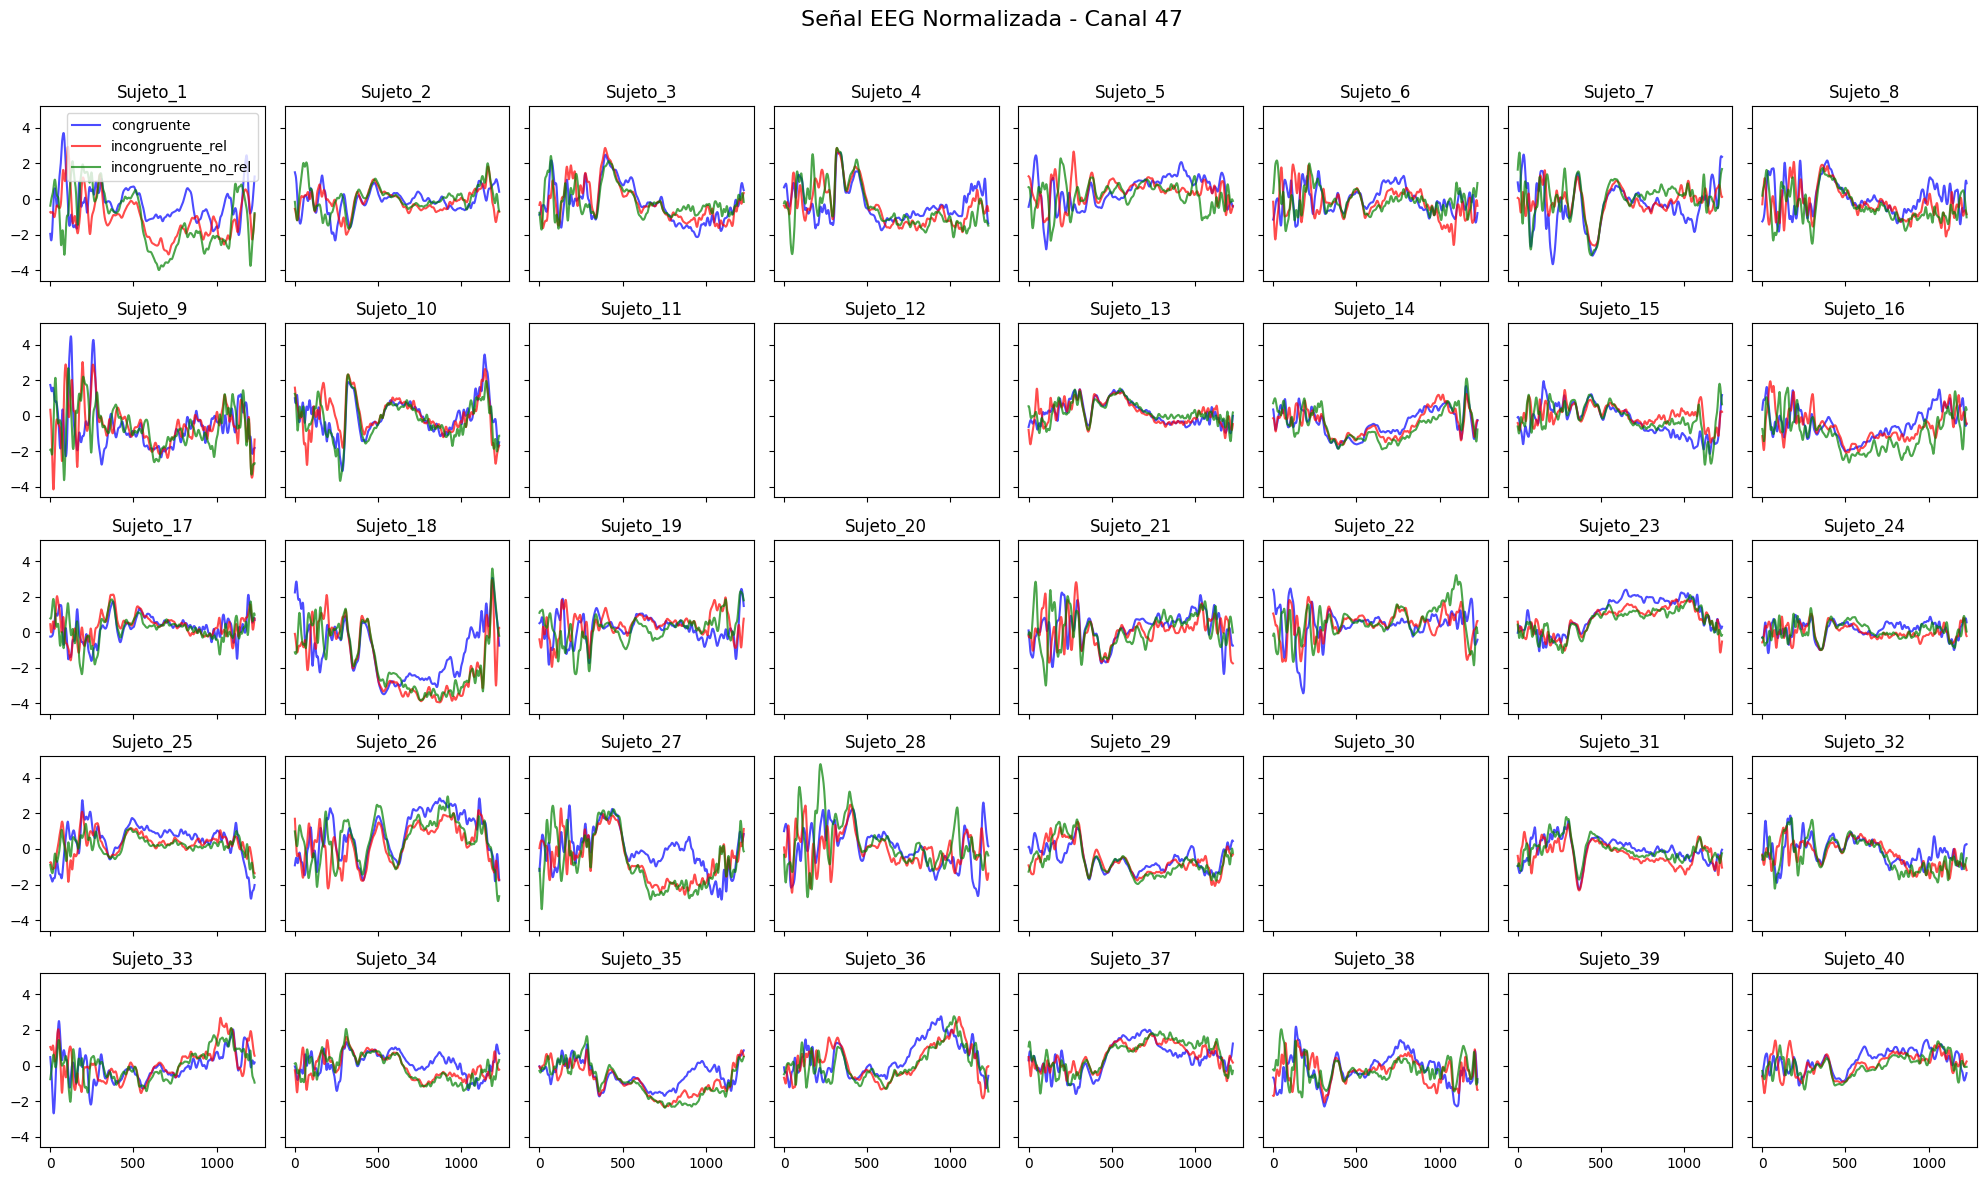

In [16]:
import matplotlib.pyplot as plt

# Definir el canal que se quiere visualizar
canal_idx = 47  # Puedes cambiar este índice para visualizar otro canal

# Crear la figura con subgráficos para 40 sujetos (5 filas x 8 columnas)
fig, axes = plt.subplots(5, 8, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle(f"Señal EEG Normalizada - Canal {canal_idx}", fontsize=16)

# Definir colores para cada condición
colores = {
    "congruente": "b",
    "incongruente_rel": "r",
    "incongruente_no_rel": "g"
}

# Verificar sujetos disponibles en registros_eeg_zscore
print("Sujetos disponibles en registros_eeg_zscore:")
for condicion in registros_eeg_zscore:
    print(f"- {condicion}: {list(registros_eeg_zscore[condicion].keys())}")

# Recorrer los sujetos (enumerados del 1 al 40)
for i, sujeto in enumerate(range(1, 41)):
    sujeto_id = f"Sujeto_{sujeto}"  # Convertir a string
    fila, columna = divmod(i, 8)  # Posición en la cuadrícula de subgráficos
    ax = axes[fila, columna]

    if sujeto_id in registros_eeg_zscore["congruente"]:  # Verificar sujeto en el diccionario
        print(f"Procesando {sujeto_id}...")  # Verificación
        for condicion, color in colores.items():
            if condicion in registros_eeg_zscore and sujeto_id in registros_eeg_zscore[condicion]:
                datos_sujeto = registros_eeg_zscore[condicion][sujeto_id]
                if datos_sujeto is not None:
                    datos = datos_sujeto.get_data()
                    print(f"{condicion} - {sujeto_id}: Shape {datos.shape}")
                    ax.plot(datos[canal_idx, :], color=color, alpha=0.7, label=condicion)
                else:
                    print(f"{condicion} - {sujeto_id}: Sin datos")
        ax.set_title(f"{sujeto_id}")
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        print(f"{sujeto_id} no tiene datos.")

# Agregar leyenda en un gráfico vacío
axes[0, 0].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Sujetos disponibles en registros_eeg_zscore:
- congruente: ['Sujeto_1', 'Sujeto_2', 'Sujeto_3', 'Sujeto_4', 'Sujeto_5', 'Sujeto_6', 'Sujeto_7', 'Sujeto_8', 'Sujeto_9', 'Sujeto_10', 'Sujeto_11', 'Sujeto_12', 'Sujeto_13', 'Sujeto_14', 'Sujeto_15', 'Sujeto_16', 'Sujeto_17', 'Sujeto_18', 'Sujeto_19', 'Sujeto_20', 'Sujeto_21', 'Sujeto_22', 'Sujeto_23', 'Sujeto_24', 'Sujeto_25', 'Sujeto_26', 'Sujeto_27', 'Sujeto_28', 'Sujeto_29', 'Sujeto_30', 'Sujeto_31', 'Sujeto_32', 'Sujeto_33', 'Sujeto_34', 'Sujeto_35', 'Sujeto_36', 'Sujeto_37', 'Sujeto_38', 'Sujeto_39', 'Sujeto_40']
- incongruente_rel: ['Sujeto_1', 'Sujeto_2', 'Sujeto_3', 'Sujeto_4', 'Sujeto_5', 'Sujeto_6', 'Sujeto_7', 'Sujeto_8', 'Sujeto_9', 'Sujeto_10', 'Sujeto_11', 'Sujeto_12', 'Sujeto_13', 'Sujeto_14', 'Sujeto_15', 'Sujeto_16', 'Sujeto_17', 'Sujeto_18', 'Sujeto_19', 'Sujeto_20', 'Sujeto_21', 'Sujeto_22', 'Sujeto_23', 'Sujeto_24', 'Sujeto_25', 'Sujeto_26', 'Sujeto_27', 'Sujeto_28', 'Sujeto_29', 'Sujeto_30', 'Sujeto_31', 'Sujeto_32', '

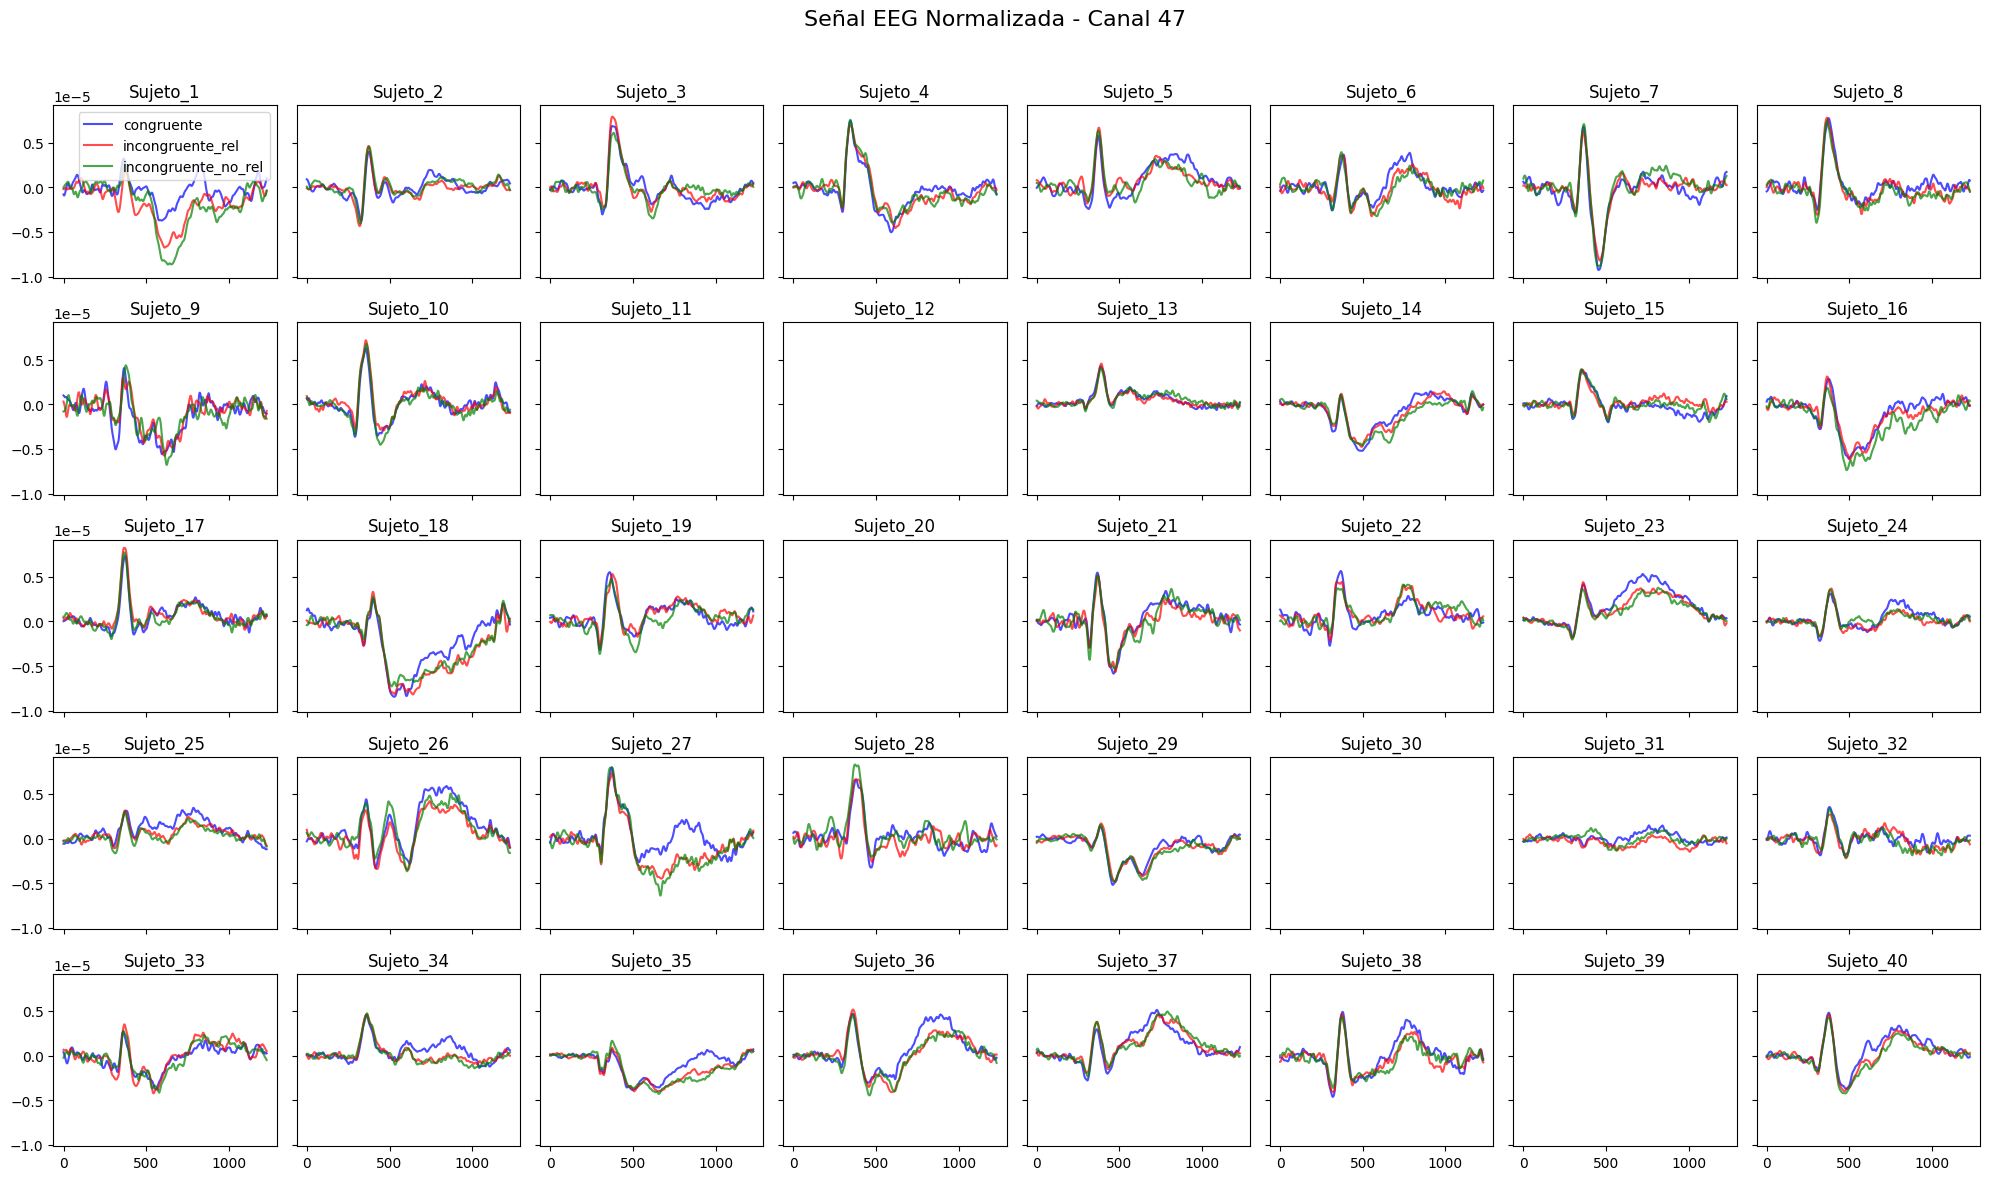

In [17]:
import matplotlib.pyplot as plt

# Definir el canal que se quiere visualizar
canal_idx = 47  # Puedes cambiar este índice para visualizar otro canal

# Crear la figura con subgráficos para 40 sujetos (5 filas x 8 columnas)
fig, axes = plt.subplots(5, 8, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle(f"Señal EEG Normalizada - Canal {canal_idx}", fontsize=16)

# Definir colores para cada condición
colores = {
    "congruente": "b",
    "incongruente_rel": "r",
    "incongruente_no_rel": "g"
}

# Verificar sujetos disponibles en registros_eeg_zscore
print("Sujetos disponibles en registros_eeg_zscore:")
for condicion in registros_eeg:
    print(f"- {condicion}: {list(registros_eeg[condicion].keys())}")

# Recorrer los sujetos (enumerados del 1 al 40)
for i, sujeto in enumerate(range(1, 41)):
    sujeto_id = f"Sujeto_{sujeto}"  # Convertir a string
    fila, columna = divmod(i, 8)  # Posición en la cuadrícula de subgráficos
    ax = axes[fila, columna]

    if sujeto_id in registros_eeg["congruente"]:  # Verificar sujeto en el diccionario
        print(f"Procesando {sujeto_id}...")  # Verificación
        for condicion, color in colores.items():
            if condicion in registros_eeg and sujeto_id in registros_eeg_zscore[condicion]:
                datos_sujeto = registros_eeg[condicion][sujeto_id]
                if datos_sujeto is not None:
                    datos = datos_sujeto.get_data()
                    print(f"{condicion} - {sujeto_id}: Shape {datos.shape}")
                    ax.plot(datos[canal_idx, :], color=color, alpha=0.7, label=condicion)
                else:
                    print(f"{condicion} - {sujeto_id}: Sin datos")
        ax.set_title(f"{sujeto_id}")
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        print(f"{sujeto_id} no tiene datos.")

# Agregar leyenda en un gráfico vacío
axes[0, 0].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [44]:
datos.get_data()

array([[ 8.88168216e-07,  8.49415541e-07,  8.07251692e-07, ...,
        -1.13115025e-06, -1.16218376e-06, -1.18952036e-06],
       [ 8.89832079e-07,  8.57314527e-07,  8.20350051e-07, ...,
        -8.73650610e-07, -9.16522384e-07, -9.69620347e-07],
       [ 5.18105090e-07,  4.82125193e-07,  4.43639070e-07, ...,
        -6.99142456e-07, -6.82085037e-07, -6.64273024e-07],
       ...,
       [-1.22490358e-06, -1.14015734e-06, -1.05584908e-06, ...,
         4.37892020e-07,  4.18836087e-07,  3.90779823e-07],
       [-1.04748023e-06, -9.87741709e-07, -9.30588603e-07, ...,
         9.54847395e-07,  9.27541673e-07,  8.89774024e-07],
       [-1.22003031e-06, -1.11602771e-06, -1.01380062e-06, ...,
         1.17750418e-06,  1.11287987e-06,  1.03160584e-06]])

In [36]:
datos_zscore.shape

(64, 1229)

In [24]:
media_por_sample

array([[ 8.09503327e-07,  7.84886417e-07,  7.61134375e-07, ...,
         2.65332363e-07,  2.10073777e-07,  1.56179315e-07],
       [ 5.46548035e-07,  5.18305593e-07,  4.88995239e-07, ...,
         1.56497381e-08,  1.49999087e-08,  1.56547014e-08],
       [ 3.83756642e-07,  3.65580204e-07,  3.43834498e-07, ...,
        -7.65670377e-08, -9.28218835e-08, -1.05783624e-07],
       ...,
       [-7.59666785e-07, -7.53344471e-07, -7.44991770e-07, ...,
        -9.21294928e-08, -5.65659537e-08, -1.91707483e-08],
       [-3.03928467e-07, -2.92466944e-07, -2.79687062e-07, ...,
         4.77829513e-07,  4.88575431e-07,  4.99716333e-07],
       [-7.47900932e-07, -7.30146502e-07, -7.11265252e-07, ...,
         3.03295274e-07,  3.44229265e-07,  3.88507957e-07]])

In [31]:
media_por_sample.shape

(64, 1229)

In [30]:
std_por_sample.shape

(64, 1229)

In [ ]:
import numpy as np
import mne

# Diccionario para almacenar los registros normalizados
registros_eeg_zscore = {cond: {} for cond in registros_eeg}

# Obtener lista de sujetos válidos
sujetos_validos = [sujeto for sujeto in registros_eeg["congruente"] if registros_eeg["congruente"][sujeto] is not None]
print("Sujetos válidos:", sujetos_validos)

if not sujetos_validos:
    raise ValueError("No hay sujetos válidos con datos EEG.")

# Obtener dimensiones de los datos EEG (Canales x Tiempos)
n_canales, n_samples = registros_eeg["congruente"][sujetos_validos[0]].get_data().shape
print(f"Dimensiones EEG: {n_canales} canales, {n_samples} samples")

# Crear matrices para almacenar la media y std (Canales x Tiempos)
media_por_sample = np.zeros((n_canales, n_samples))
std_por_sample = np.zeros((n_canales, n_samples))

# Apilar los datos de todos los sujetos en una matriz (Sujetos x Canales x Tiempos)
datos_sujetos = np.array([
    registros_eeg["congruente"][sujeto].get_data()
    for sujeto in sujetos_validos
])  # (Sujetos, Canales, Tiempos)
print("Datos sujetos shape:", datos_sujetos.shape)

# Calcular la media y std entre sujetos para cada sample y canal
media_por_sample = np.mean(datos_sujetos, axis=0)  # (Canales, Tiempos)
std_por_sample = np.std(datos_sujetos, axis=0)  # (Canales, Tiempos)
print("Media shape:", media_por_sample.shape, "Std shape:", std_por_sample.shape)

# Evitar divisiones por cero
std_por_sample = np.where(std_por_sample == 0, 1, std_por_sample)

# Aplicar Z-score para cada sujeto y condición
for condicion in registros_eeg:
    print(f"Procesando condición: {condicion}")
    for sujeto in registros_eeg[condicion]:
        if registros_eeg[condicion][sujeto] is not None:
            datos_sujeto = registros_eeg[condicion][sujeto].get_data()
            print(f"{sujeto} - {condicion}: Datos shape {datos_sujeto.shape}")

            # Normalizar usando la media y std calculada entre sujetos
            datos_zscore = (datos_sujeto - media_por_sample) / std_por_sample

            # Crear un nuevo objeto RawArray con los datos normalizados
            info = registros_eeg[condicion][sujeto].info
            registros_eeg_zscore[condicion][sujeto] = mne.io.RawArray(datos_zscore, info)
            print(f"{sujeto} - {condicion}: Z-score aplicado.")
        else:
            registros_eeg_zscore[condicion][sujeto] = None


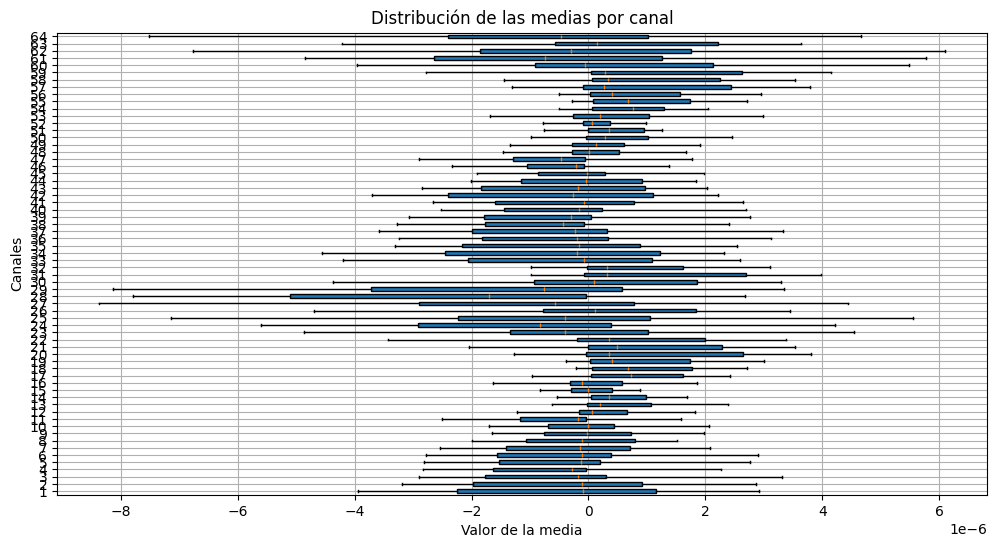

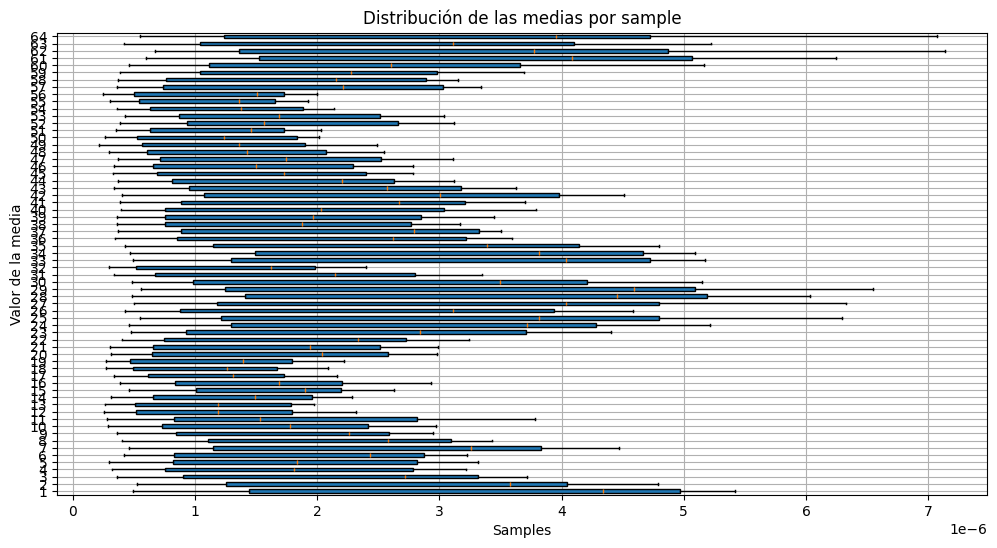

In [33]:
# Gráfico 1: Boxplot de media_por_sample por canal
plt.figure(figsize=(12, 6))
plt.boxplot(media_por_sample.T, vert=False, patch_artist=True, showfliers=False)
plt.xlabel("Valor de la media")
plt.ylabel("Canales")
plt.title("Distribución de las medias por canal")
plt.grid(True)
plt.show()

# Gráfico 2: Boxplot de media_por_sample por sample
plt.figure(figsize=(12, 6))
plt.boxplot(std_por_sample.T, vert=False, patch_artist=True, showfliers=False)
plt.xlabel("Samples")
plt.ylabel("Valor de la media")
plt.title("Distribución de las medias por sample")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import mne

def calcular_z_score_por_sample(registros_eeg, verbose=False):
    """
    Normaliza los datos EEG usando Z-score calculado a nivel de sample,
    considerando la media y desviación estándar entre todos los sujetos disponibles.

    Argumentos:
    registros_eeg : dict
        Diccionario con los registros EEG en formato mne.io.RawArray.
    verbose : bool
        Si es True, imprime mensajes de depuración.

    Retorna:
    registros_eeg_zscore : dict
        Diccionario con los registros normalizados.
    """

    registros_eeg_zscore = {cond: {} for cond in registros_eeg}

    # Obtener lista de sujetos válidos (que tienen datos)
    sujetos_validos = [sujeto for sujeto in registros_eeg["congruente"] if registros_eeg["congruente"][sujeto] is not None]

    if not sujetos_validos:
        raise ValueError("No hay sujetos válidos con datos EEG.")

    # Obtener dimensiones de los datos EEG (Canales x Tiempos)
    n_canales, n_samples = registros_eeg["congruente"][sujetos_validos[0]].get_data().shape

    # Crear matrices para almacenar la media y std (Canales x Tiempos)
    media_por_sample = np.zeros((n_canales, n_samples))
    std_por_sample = np.zeros((n_canales, n_samples))

    # Apilar los datos de todos los sujetos en una matriz (Sujetos x Canales x Tiempos)
    datos_sujetos = np.array([
        registros_eeg["congruente"][sujeto].get_data()
        for sujeto in sujetos_validos
    ])  # (Sujetos, Canales, Tiempos)

    # Calcular la media y std entre sujetos para cada sample y canal
    media_por_sample = np.mean(datos_sujetos, axis=0)  # (Canales, Tiempos)
    std_por_sample = np.std(datos_sujetos, axis=0)  # (Canales, Tiempos)

    # Evitar divisiones por cero usando np.where
    std_por_sample = np.where(std_por_sample == 0, 1, std_por_sample)

    # Aplicar Z-score para cada sujeto y condición
    for condicion in registros_eeg:
        for sujeto in registros_eeg[condicion]:
            if registros_eeg[condicion][sujeto] is not None:
                datos_sujeto = registros_eeg[condicion][sujeto].get_data()

                # Normalizar usando la media y std calculada entre sujetos
                datos_zscore = (datos_sujeto - media_por_sample) / std_por_sample

                # Crear un nuevo objeto RawArray con los datos normalizados
                info = registros_eeg[condicion][sujeto].info
                registros_eeg_zscore[condicion][sujeto] = mne.io.RawArray(datos_zscore, info)

                if verbose:
                    print(f"{sujeto} - {condicion}: Normalización Z-score aplicada.")
            else:
                registros_eeg_zscore[condicion][sujeto] = None  # Mantener sujetos sin datos

    return registros_eeg_zscore

# Aplicar la normalización con verbose=True para ver el progreso
registros_eeg_zscore = calcular_z_score_por_sample(registros_eeg, verbose=True)


In [16]:
registros_eeg_zscore['congruente']['Sujeto_1'].get_data()

array([[ 0.00313507,  0.03568015,  0.07931473, ...,  0.45200625,
         0.40848974,  0.36266339],
       [ 0.48907584,  0.53732141,  0.5872816 , ...,  0.95039805,
         0.85328017,  0.7467443 ],
       [-0.47779578, -0.46334095, -0.44509193, ..., -0.7105232 ,
        -0.6704809 , -0.61168552],
       ...,
       [-0.14280318, -0.15267177, -0.14789909, ..., -0.6592816 ,
        -0.61581028, -0.56386092],
       [ 0.99019798,  0.98932539,  0.98594544, ...,  1.20360963,
         1.17977368,  1.15583304],
       [ 0.4472436 ,  0.49757502,  0.52937054, ...,  0.59477399,
         0.60018264,  0.60555497]])

In [10]:
import numpy as np
import mne

def calcular_grand_average(registros_eeg_zscore):
    """
    Calcula el Grand Average (promedio entre sujetos) para cada condición.

    Parámetro:
    - registros_eeg_zscore: Diccionario con los datos EEG normalizados.

    Retorna:
    - grand_average: Diccionario con los promedios por condición.
    """
    grand_average = {}

    for condicion in registros_eeg_zscore:
        datos_acumulados = []
        info_referencia = None  # Para guardar la metadata de un sujeto válido

        for sujeto in registros_eeg_zscore[condicion]:
            if registros_eeg_zscore[condicion][sujeto] is not None:
                datos_sujeto = registros_eeg_zscore[condicion][sujeto].get_data()  # (Canales x Tiempos)
                datos_acumulados.append(datos_sujeto)

                # Guardamos la info del primer sujeto válido
                if info_referencia is None:
                    info_referencia = registros_eeg_zscore[condicion][sujeto].info

        if len(datos_acumulados) == 0:
            print(f"No hay datos válidos para la condición {condicion}.")
            grand_average[condicion] = None
            continue

        # Convertir lista a array y promediar entre sujetos (manteniendo Canales x Tiempos)
        datos_promedio = np.mean(np.array(datos_acumulados), axis=0)

        # Crear un RawArray con los datos promediados
        grand_average[condicion] = mne.io.RawArray(datos_promedio, info_referencia)

    return grand_average

# Calcular el Grand Average
grand_average = calcular_grand_average(registros_eeg_zscore)

# Imprimir resumen de los resultados
for condicion, data in grand_average.items():
    if data is not None:
        print(f"Grand Average para {condicion}: {data}")
    else:
        print(f"No se pudo calcular el Grand Average para {condicion}.")


Creating RawArray with float64 data, n_channels=64, n_times=1229
    Range : 0 ... 1228 =      0.000 ...     1.199 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=1229
    Range : 0 ... 1228 =      0.000 ...     1.199 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=1229
    Range : 0 ... 1228 =      0.000 ...     1.199 secs
Ready.
Grand Average para congruente: <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>
Grand Average para incongruente_rel: <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>
Grand Average para incongruente_no_rel: <RawArray | 64 x 1229 (1.2 s), ~690 kB, data loaded>


In [59]:
grand_average['congruente'].get_data().shape

(64, 1229)

In [11]:
df_electrodes = grand_average['congruente'].ch_names

In [13]:
df_electrodes

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2']

In [15]:
df_electrodes[47]

'Cz'

In [60]:
import numpy as np

pools = {
    "FrontoCentral": ['C1', 'C2', 'Cz', 'FC1', 'FC2', 'FCz'],
    "Fronto": ['F1', 'F2', 'FC1', 'FC2', 'FCz', 'Fz'],
    "Frontal": ['F1', 'F2', 'FCz', 'Fz'],
    "Cz": ['Cz'],
    "Parietal": ['POz', 'Pz'],
    "Occipital": ['Iz', 'O1', 'O2', 'Oz']
}

EEG_pool_data = {}

for condition, raw_data in grand_average.items():
    pool_dict = {}
    
    # Obtener los datos como array numpy (shape: [n_channels, n_samples])
    data = raw_data.get_data()
    
    for pool_name, electrodes in pools.items():
        # Obtener los índices de los electrodos en la lista df_electrodes
        indices = [df_electrodes.index(e) for e in electrodes if e in df_electrodes]

        if indices:  # Asegurarse de que no esté vacío
            pool_data = data[indices, :]  # Extraer datos
            pool_dict[pool_name] = np.mean(pool_data, axis=0)  # Promediar
        else:
            pool_dict[pool_name] = None  # O np.nan si prefieres valores numéricos

    EEG_pool_data[condition] = pool_dict

print("Procesamiento completado sin errores")


Procesamiento completado sin errores


In [63]:
EEG_pool_data

{'congruente': {'FrontoCentral': array([ 2.66982204e-17, -3.13241496e-17,  1.24239243e-17, ...,
          1.94949876e-18,  1.91645641e-17, -1.22917549e-17]),
  'Fronto': array([ 5.86832170e-17, -1.05735526e-18,  0.00000000e+00, ...,
         -3.96508223e-18, -8.72318091e-18, -5.81545394e-18]),
  'Frontal': array([ 5.07530526e-17,  1.82393783e-17,  3.08148791e-33, ...,
          1.98254112e-18, -2.10149358e-17, -7.53365624e-18]),
  'Cz': array([6.97854473e-17, 9.51619735e-18, 1.11022302e-17, ...,
         1.90323947e-17, 4.59949539e-17, 2.69625592e-17]),
  'Parietal': array([ 1.26882631e-17, -1.26882631e-17, -1.58603289e-18, ...,
          4.91670197e-17,  2.37904934e-17,  2.37904934e-18]),
  'Occipital': array([-1.14194368e-16,  1.74463618e-17, -1.23908820e-17, ...,
         -3.88578059e-17, -4.75809868e-18, -3.96508223e-19])},
 'incongruente_rel': {'FrontoCentral': array([-0.01973633, -0.03257888, -0.04777249, ..., -0.43370332,
         -0.40564916, -0.37584372]),
  'Fronto': array([ 

In [10]:
eeg_time_dict = {condition: np.linspace(0, len(data.times)-1, len(data.times)) for condition, data in grand_average.items()}


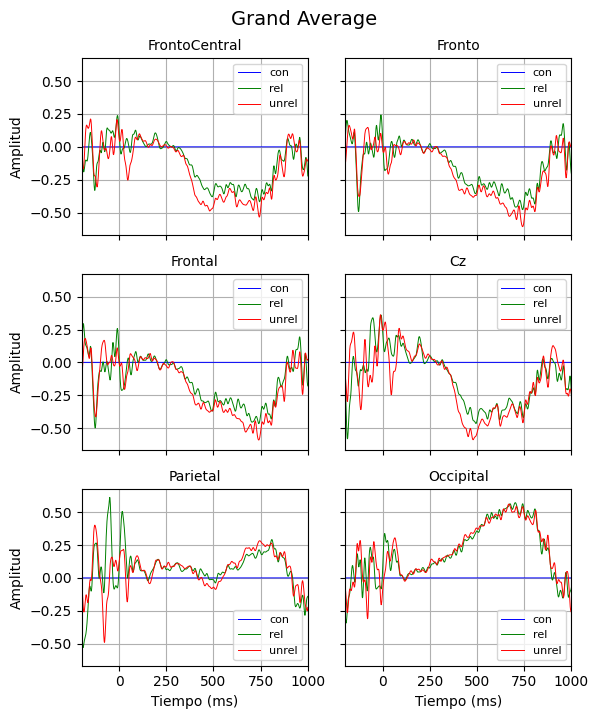

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Diccionario para abreviar nombres de condiciones
legend_labels = {
    'congruente': 'con',
    'incongruente_rel': 'rel',
    'incongruente_no_rel': 'unrel'
}

# Función para graficar los datos EEG en un diseño 3x2 con señales superpuestas
def plot_pools_superposed(time_dict, EEG_pool_data, condition_keys, pools, title, line_width=2):
    """
    Grafica las señales EEG en un diseño de 3x2, donde:
    - Cada gráfico corresponde a un pool.
    - Las tres condiciones actuales están superpuestas en cada gráfico.
    - Permite ajustar el grosor de las líneas con `line_width`.
    """
    n_pools = len(pools)

    # Crear figura con tamaño ajustado
    fig, axes = plt.subplots(3, 2, figsize=(6, 7), sharex=True, sharey=True)

    # Asegurar que axes sea un array 2D
    axes = np.atleast_2d(axes).flatten()

    # Definir colores específicos para cada condición
    colors = ['b', 'g', 'r']  

    # Iterar sobre cada pool y asignarlo a un subplot
    for i, (pool_name, electrodes) in enumerate(pools.items()):
        ax = axes[i]  # Seleccionar el subplot correspondiente

        # Graficar cada condición en el mismo subplot
        for j, condition in enumerate(condition_keys):
            time = np.array(time_dict[condition]) - 200  # Restar 200 ms al tiempo
            signal = EEG_pool_data[condition][pool_name]
            ax.plot(time, signal, label=legend_labels[condition], color=colors[j], linewidth=line_width)  # Usar etiquetas abreviadas

        # Configurar el rango del eje X para que vaya de -200 ms a 1000 ms
        ax.set_xlim([-200, 1000])

        # Configuración del subplot
        ax.set_title(f"{pool_name}", fontsize=10)
        ax.grid(True)
        ax.legend(fontsize=8)  # Reducir tamaño de la leyenda

        # Etiqueta del eje Y solo en la primera columna
        if i % 2 == 0:
            ax.set_ylabel("Amplitud", fontsize=10)

        # Etiqueta del eje X solo en la última fila
        if i >= n_pools - 2:
            ax.set_xlabel("Tiempo (ms)", fontsize=10)

    # Eliminar ejes vacíos si hay menos de 6 pools
    for i in range(n_pools, 6):
        fig.delaxes(axes[i])

    # Ajustar diseño de la figura
    plt.tight_layout()
    plt.suptitle(title, fontsize=14, y=1.02)  # Título general
    plt.show()


# Llamar a la función con grosor de línea ajustado
plot_pools_superposed(
    eeg_time_dict, 
    EEG_pool_data, 
    ['congruente', 'incongruente_rel', 'incongruente_no_rel'],  # Condiciones actuales superpuestas
    pools,  # Pools (máximo 6)
    'Grand Average',  # Título general
    line_width=0.7  # Ajusta el grosor de las líneas aquí
)
